<a href="https://colab.research.google.com/github/AbidYousuf/Abid-Yousuf/blob/main/FunctionalAPINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Model

In [ ]:
from keras.layers import*

**1.Simple Example one input multiple outputs**

In [ ]:
x = Input(shape=(3,))
h1 = Dense(128,activation='relu')(x)
h2 = Dense(64,activation='relu')(h1)

o1 = Dense(1,activation='linear')(h2)
o2 = Dense(1,activation='sigmoid')(h2)
model = Model(inputs=x,outputs=[o1,o2])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 128)                  512       ['input_3[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 64)                   8256      ['dense_4[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 1)                    65        ['dense_5[0][0]']             
                                                                                            

In [ ]:
from keras.utils import plot_model

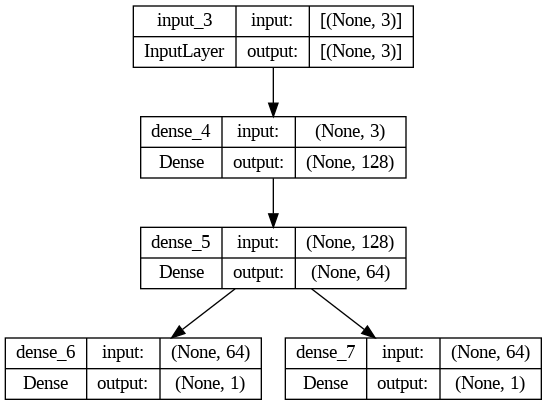

In [ ]:
plot_model(model,show_shapes=True)

**2.Multiple input one output**

In [ ]:
#Define two set of inputs
input1 = Input(shape=(32,))
input2 = Input(shape=(128,))

In [ ]:
#The first branch operates on the first input
d1 = Dense(8,activation='relu')(input1)
d2 = Dense(4,activation='relu')(d1)

In [ ]:
#The second branch operates on the second input
h1 = Dense(64,activation='relu')(input2)
h2 = Dense(32,activation='relu')(h1)
h3 = Dense(16,activation='relu')(h2)

In [ ]:
#combine the output of two branches
combined = concatenate([d2,h3])

In [ ]:
fc1 = Dense(2,activation='relu')(combined)
fc2 = Dense(1,activation='linear')(fc1)

In [ ]:
model = Model(inputs=[input1,input2],outputs=fc2)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 dense_18 (Dense)            (None, 64)                   8256      ['input_7[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 8)                    264       ['input_6[0][0]']             
                                                                                            

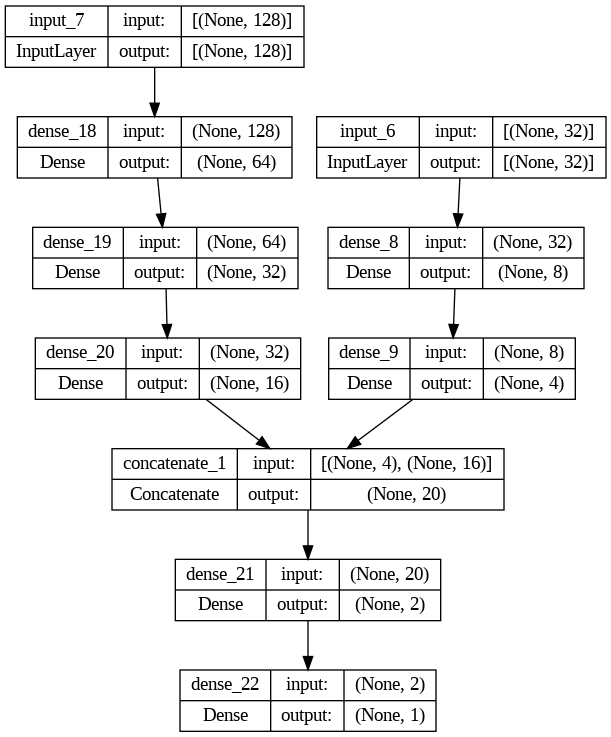

In [ ]:
plot_model(model,show_shapes=True)

**3.Multi output Model**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 329M/331M [00:06<00:00, 34.5MB/s]
100% 331M/331M [00:06<00:00, 55.9MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
ds_path = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(ds_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [ ]:
df.head()

,age,gender,img
0,26,1,26_1_3_20170117153340356.jpg.chip.jpg
1,61,1,61_1_3_20170105001450436.jpg.chip.jpg
2,35,0,35_0_1_20170117173329389.jpg.chip.jpg
3,34,1,34_1_3_20170109141950796.jpg.chip.jpg
4,90,1,90_1_1_20170113184500142.jpg.chip.jpg


In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=ds_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=ds_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [ ]:
vgg = VGG16(include_top=False,input_shape=(200,200,3))
vgg.trainable = False
output = vgg.layers[-1].output
flatten = Flatten()(output)
d1 = Dense(512,activation='relu')(flatten)
d2 = Dense(512,activation='relu')(flatten)

d3 = Dense(512,activation='relu')(d1)
d4 = Dense(512,activation='relu')(d2)

o1 = Dense(1,activation='linear',name='age')(d3)
o2 = Dense(1,activation='sigmoid',name='gender')(d4)

model = Model(inputs=vgg.input,outputs=[o1,o2])


58889256/58889256 [==============================] - 0s 0us/step


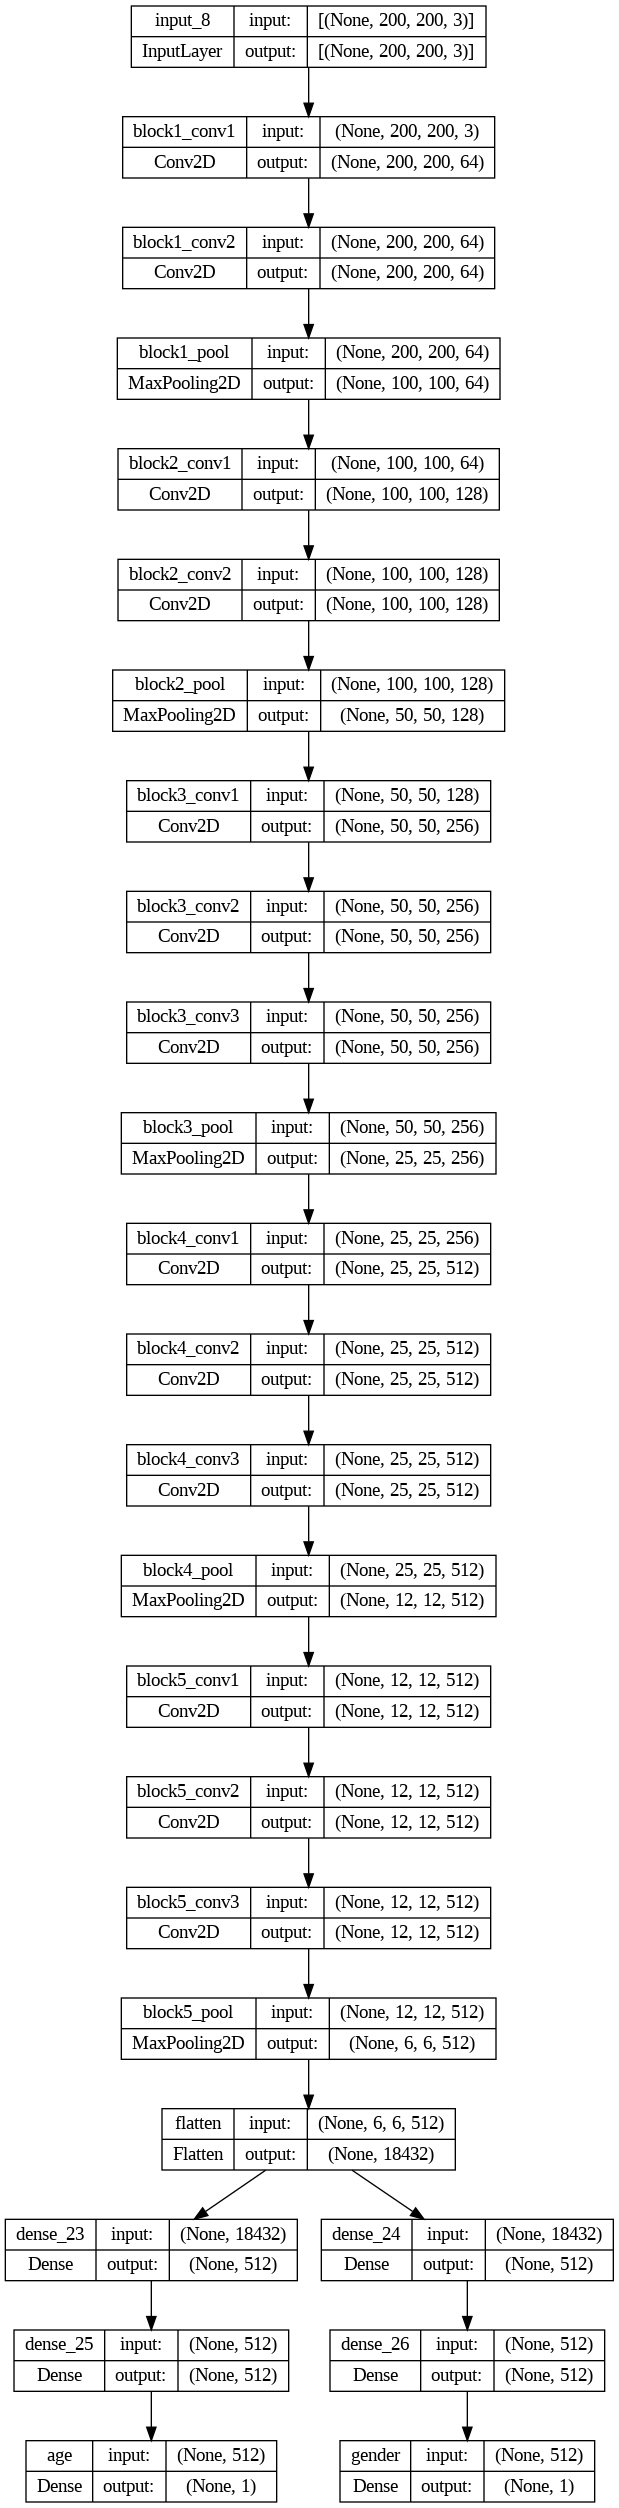

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [ ]:
model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
 13/625 [..............................] - ETA: 2:26:44 - loss: 138.0803 - age_loss: 19.1755 - gender_loss: 1.2011 - age_mae: 19.1755 - gender_accuracy: 0.5048

KeyboardInterrupt: 